# Coral Reef Dataset Preparation
This notebook prepares the CoralConditionDataset for machine learning models. We'll clean the data, process labels for multi-label classification, and split the data into train/val/test sets.

In [7]:
# Correct working directory.
# This is necessary for imports because the notebook is not in the main folder of the project.
if not "working_directory_corrected" in vars():
    %cd ..
    working_directory_corrected = True

# Import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from data.coral_condition_dataset import CoralConditionDataset, CoralImageProcessor

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

## 1. Data Cleaning

First, we'll handle the data issues identified during exploration:
- 11 images have annotations but are missing from the images folder.
- 1,611 images exist but have no annotations.

In [2]:
# Initialize dataset
dataset = CoralConditionDataset()
annotations = dataset.ANNOTATIONS_PATH.copy()

# Get list of missing images (from exploration notebook)
with open("missing_images.txt") as f:
    missing_images = [line.strip() for line in f.readlines()]

# Remove annotations for missing images
print(f"Original annotations: {len(annotations)}")
annotations = annotations[annotations["patchid"].isin(missing_images) == False]
print(f"After removing missing: {len(annotations)}")

# Verify all remaining images have annotations
existing_images = {os.path.splitext(f)[0] for f in os.listdir(dataset.IMAGES_PATH) if f.endswith('.jpg')}
missing_in_clean = set(annotations["patchid"]) - existing_images
if missing_in_clean:
    print(f"{len(missing_in_clean)} images in annotations are missing from the images folder")

# Save cleaned annotations
annotations.to_csv("data/coral_condition/annotations_cleaned.csv", index=False)
print("Saved cleaned annotations")

Original annotations: 23965
After removing missing: 23954
Saved cleaned annotations


In [3]:
# Get list of all image files
all_images = {f for f in os.listdir(dataset.IMAGES_PATH) if f.endswith('.jpg')}

# Get annotated images
annotated_images = {f"{patchid}.jpg" for patchid in annotations['patchid']}

# Find images without annotations
unannotated_images = all_images - annotated_images
print(f"Found {len(unannotated_images)} unannotated images")

# Move unannotated images to separate folder
os.makedirs(os.path.join(dataset.IMAGES_PATH, 'unannotated'), exist_ok=True)
for img in unannotated_images:
    src = os.path.join(dataset.IMAGES_PATH, img)
    dst = os.path.join(dataset.IMAGES_PATH, 'unannotated', img)
    os.rename(src, dst)

Found 1622 unannotated images


We now have a cleaned annotations file excluding the annotations with missing images, and moved images that have no annotations into a separate folder. 
The cleaned dataset is now ready for further processing.

# 2. Label Processing
Our dataset contains images with multiple labels. Before training the model, we need the labels to be in binary matrix format and map the label IDs to their names. We have already done this in the data exploration stage to create the NPMI, which means we can just reuse it.

In [10]:
# Get preprocessed annotations from clean data
dataset = CoralConditionDataset(annotations_file="annotations_cleaned.csv")
annotations = dataset.get_preprocessed_annotations()

# Display label names mapping
label_names = dataset.LABELSET_PATH.set_index('label')['label_name'].to_dict()
print("Label Names Mapping:")
for id, name in label_names.items():
    print(f"{id}: {name}")

# Get binary labels 
binary_labels = dataset.binary_matrix.values
label_columns = [label_names[i] for i in dataset.mlb.classes_]

# Create and display binary labels DataFrame
binary_df = pd.DataFrame(binary_labels, columns=label_columns)
print("\nBinary Label Matrix Samples:")
display(binary_df.head(3))


Label Names Mapping:
0: Background
1: Healthy coral
2: Compromised coral
3: Dead coral
4: Rubble
5: Competition
6: Disease
7: Predation
8: Physical issues

Binary Label Matrix Samples:


,Background,Healthy coral,Compromised coral,Dead coral,Rubble,Competition,Disease,Predation,Physical issues
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0


We now have a binary matrix where each row represents an image and columns represent labels. 1 indicates the presence of that label, and 0 indicates the absence of the label.

# 3. Dataset Splitting
We need to split our data while preserving the multi-label distribution and making sure all splits have representative examples of rare classes. We also want to make sure we can reproduce the splits.

In [11]:
# Split dataset into train, val, and test
(X_train, y_train), (X_val, y_val), (X_test, y_test) = dataset.split_dataset()

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}") 
print(f"Test samples: {len(X_test)}")

# Verify class distribution
def print_class_distribution(y, class_names, split_name):
    print(f"\n{split_name} Class Distribution:")
    class_counts = y.sum(axis=0)
    for name, count in zip(class_names, class_counts):
        print(f"{name}: {count} ({count/len(y):.1%})")

class_names = dataset.LABELSET_PATH['label_name'].tolist()
print_class_distribution(y_train, class_names, "Training")
print_class_distribution(y_val, class_names, "Validation") 
print_class_distribution(y_test, class_names, "Test") 

Training samples: 16767
Validation samples: 2396
Test samples: 4791

Training Class Distribution:
Background: 765 (4.6%)
Healthy coral: 12125 (72.3%)
Compromised coral: 4862 (29.0%)
Dead coral: 6404 (38.2%)
Rubble: 1775 (10.6%)
Competition: 2095 (12.5%)
Disease: 2011 (12.0%)
Predation: 515 (3.1%)
Physical issues: 2015 (12.0%)

Validation Class Distribution:
Background: 109 (4.5%)
Healthy coral: 1733 (72.3%)
Compromised coral: 677 (28.3%)
Dead coral: 948 (39.6%)
Rubble: 239 (10.0%)
Competition: 288 (12.0%)
Disease: 297 (12.4%)
Predation: 77 (3.2%)
Physical issues: 277 (11.6%)

Test Class Distribution:
Background: 218 (4.6%)
Healthy coral: 3465 (72.3%)
Compromised coral: 1370 (28.6%)
Dead coral: 1837 (38.3%)
Rubble: 502 (10.5%)
Competition: 565 (11.8%)
Disease: 584 (12.2%)
Predation: 139 (2.9%)
Physical issues: 582 (12.1%)


The split uses 70% of the dataset for training, 10% for validation, and 20% for testing. We stratify by each sample's most frequent class. Stratification is applied to ensure each split has a similar label distribution, which is critical for multi-label data. The function also uses random_state=42 is used to make splits reproducible. 

# 4. Class Imbalance
We need to calculate class weights to handle imbalance during the training phase. Some models (e.g. ResNet) need class weights to properly learn rare classes. Without weights, the model can end up focusing more on frequent classes.

In [10]:
# Calculate class weights
class_weights = dataset.calculate_class_weights(y_train)
print("\nClass weights for handling imbalance:")
for id, weight in sorted(class_weights.items()):
    print(f"{id}: {label_names[id]}: {weight:.2f}")


Class weights for handling imbalance:
0: Background: 2.44
1: Healthy coral: 0.15
2: Compromised coral: 0.38
3: Dead coral: 0.29
4: Rubble: 1.05
5: Competition: 0.89
6: Disease: 0.93
7: Predation: 3.62
8: Physical issues: 0.92


Rare classes (e.g. Predation) get higher weights while common classes (e.g. Healthy coral) get lower weights. We inversely weighted each class based on its frequency so that during training, the loss function can pay more attention to rare samples. This helps balance learning despite uneven class/label distribution.

# 5. Image Preprocessing
We will set up an image processor that will:
- Normalize images by converting pixel values to 0-1 range.
- Augment images during training with random horizontal/vertical flips and 90° rotations (50% probability each). 

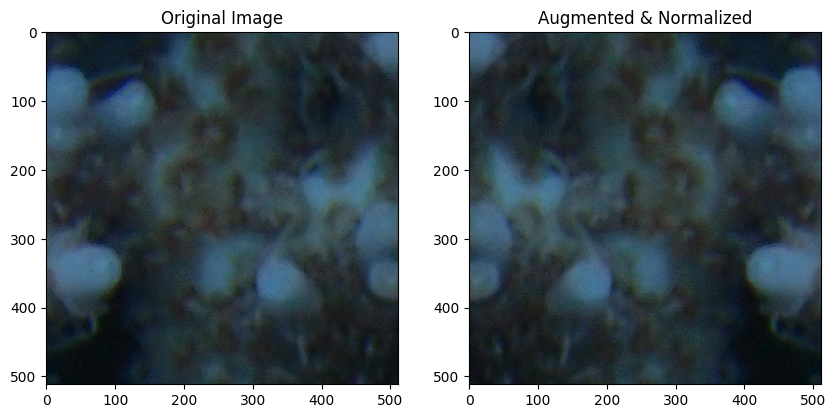

In [11]:
# Initialize image processor
processor = CoralImageProcessor(dataset.IMAGES_PATH)

# Test image processor
sample_image_id = X_train.iloc[0]
sample_img = processor.load_image(sample_image_id)
processed_img = processor.preprocess(sample_image_id, augment=True)

# Visualize before/after
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original Image")

plt.subplot(1, 2, 2)

# Denormalize for visualization
denormalized = (processed_img * processor.std) + processor.mean
denormalized = np.clip(denormalized, 0, 1)
plt.imshow(denormalized)
plt.title("Augmented & Normalized")
plt.show()

Augmenting the images during training can help prevent overfitting by creating training variations to improve generalization.

# Conclusion
We have prepared the data for machine learning by:
- cleaning our data by removing missing annotations and images.
- creating binaries for our classes.
- splitting the dataset using stratification.
- calculated class-weights to use when training the model to address the imbalance of the dataset.
- normalized and augmented training samples.

Next, we can explore models to select.